# SETUP

## Check environment

In [58]:
USE_GPU = True

In [59]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: True


In [60]:
!pip install --upgrade pip tensorflow keras scikit-learn &> pip.log
!pip install openpyxl pydot >> pip.log
!apt-get install graphviz -y &> apt.log

if USE_GPU:
    !pip install 'tensorflow[and-cuda]' >> pip.log
else:
    !pip install 'tensorflow-cpu' >> pip.log

In [61]:
if not COLAB:
    !pip install jupyterlab-vim jupyterlab-indent-guides >> pip.log

## Libraries

In [62]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM, predictLSTMNoSplit
from src.time_series_utils import prepareReducedData

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [63]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params_colab.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/content/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "aod2021": {
            "file_dir": "/content/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/content/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/content/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/content/air_quality_index_project/dataset/station2018-2021.csv",
            "merged_data_dir": "/content/air_quality_index_project/dataset/mpair_merged.csv"
        }
    },
    "workspace": {
        "model_info_dir": "/content/model_info",
        "model_checkpoints_dir": "/content/model_checkpoints",
        "data_by

# AOD DATA

## Load 2022 dataset

In [64]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [65]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,aod,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
2022-01-01,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2022-01-01,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-01-01,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-01-02,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-12-30,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-12-31,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486


## Load 2021 dataset

In [66]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


,time,ID,pm25,Lat,Lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,1/1/2018,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1,1/1/2018,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2,1/2/2018,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
3,1/2/2018,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
4,1/3/2018,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,12/31/2021,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,12/31/2021,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,12/31/2021,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,12/31/2021,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [67]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021.index >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021.index <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,14886.63672,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2021-12-31,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,35151.59375,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2021-12-31,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,27580.67383,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610


## Merge dataset

In [68]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Print
df_aod_raw

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [69]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [70]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [71]:
df_aod_raw.isnull().sum()

,0
station,0
pm25,0
lat,0
lon,0
pm25_3km,0
tmp,0
rh,0
hpbl,0
wspd,0
pop,0


## Preprocessing

### Define label, static features and dynamic features

In [72]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['hpbl', 'rh', 'pm25_3km', 'aod', 'tmp', 'wspd']
aod_all_stations = [np.int64(201), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column

In [73]:
all_stations_df = []

for station in aod_all_stations:
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())

    # Store file for debugging after filling missing values
    df_aod_current_station.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [74]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations

In [75]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [76]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

,station
time,
2021-01-01,201
2021-01-02,201
2021-01-03,201
2021-01-04,201
2021-01-05,201
...,...
2022-12-27,216
2022-12-28,216
2022-12-29,216


### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [77]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats
# Predict without "station" as a feature
aod_feats.remove("station")
X_aod = df_aod.loc[:, aod_feats]

# Features without pm25_3km
aod_feats.remove("pm25_3km")
X_aod_no_pm25_3km = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [78]:
X_aod

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,hpbl,rh,pm25_3km,aod,tmp,wspd
time,,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,561.605774,60.583508,38.320000,0.582774,25.873598,3.548874
2021-01-02,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,527.248901,60.219109,56.650002,0.582774,25.527328,2.355864
2021-01-03,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,469.774841,61.481564,56.900002,0.582774,26.878422,1.896463
2021-01-04,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,615.690735,61.013718,61.560001,0.582774,27.771753,1.642178
2021-01-05,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,665.619263,61.277409,69.949997,0.582774,27.660774,2.859253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,457.798645,73.973083,34.439411,0.535331,24.136936,2.002987
2022-12-28,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,644.974548,65.530487,29.838476,0.535331,25.844296,2.298220
2022-12-29,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,825.517395,67.093735,28.450829,0.191691,25.841156,2.823764


In [79]:
X_aod_no_pm25_3km

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,hpbl,rh,aod,tmp,wspd
time,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,561.605774,60.583508,0.582774,25.873598,3.548874
2021-01-02,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,527.248901,60.219109,0.582774,25.527328,2.355864
2021-01-03,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,469.774841,61.481564,0.582774,26.878422,1.896463
2021-01-04,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,615.690735,61.013718,0.582774,27.771753,1.642178
2021-01-05,10.783057,106.700606,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,665.619263,61.277409,0.582774,27.660774,2.859253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,457.798645,73.973083,0.535331,24.136936,2.002987
2022-12-28,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,644.974548,65.530487,0.535331,25.844296,2.298220
2022-12-29,10.780482,106.659511,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,825.517395,67.093735,0.191691,25.841156,2.823764


In [80]:
y_aod

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


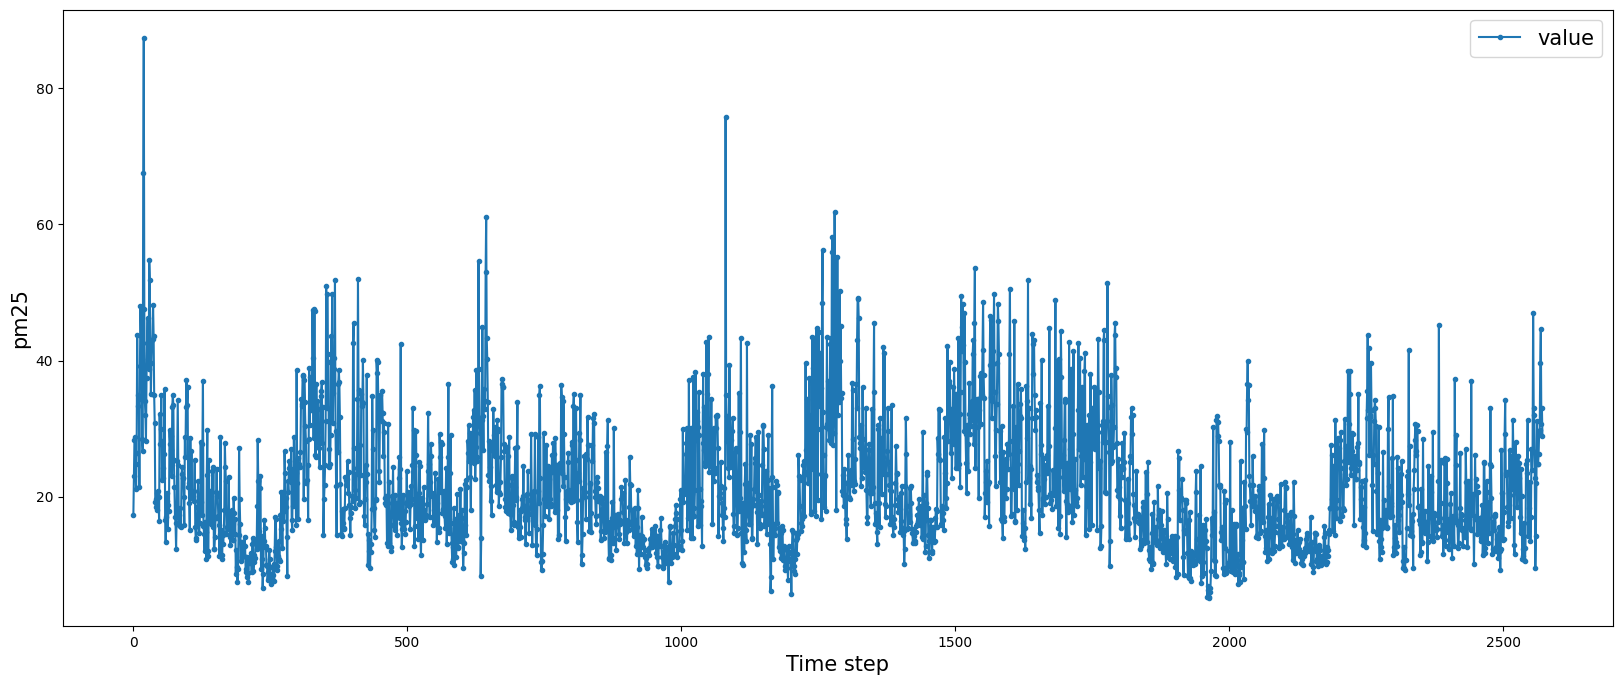

In [81]:
plot_1_data(data=y_aod, datalabel="value", xlabel="Time step", ylabel="pm25")

### Data normalization

In [82]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,hpbl,rh,pm25_3km,aod,tmp,wspd
0,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.382113,0.265635,0.401465,0.175961,0.292466,0.485894
1,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.355779,0.257407,0.625275,0.175961,0.259187,0.251463
2,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.311726,0.285912,0.628327,0.175961,0.389039,0.161190
3,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.423568,0.275348,0.685226,0.175961,0.474896,0.111222
4,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.461837,0.281302,0.787668,0.175961,0.464230,0.350381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.302546,0.567964,0.354083,0.160199,0.125557,0.182122
2569,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.446013,0.377335,0.297906,0.160199,0.289650,0.240136
2570,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.584396,0.412632,0.280963,0.046031,0.289348,0.343407
2571,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.473268,0.362385,0.176000,0.160199,0.206556,0.553589


In [83]:
# Scaled features without pm25_3km
aod_features_no_pm25_3km_scaler = MinMaxScaler()
X_aod_no_pm25_3km_scaled = aod_features_no_pm25_3km_scaler.fit_transform(X_aod_no_pm25_3km)
X_aod_no_pm25_3km_scaled = pd.DataFrame(X_aod_no_pm25_3km_scaled, columns=X_aod_no_pm25_3km.columns)
X_aod_no_pm25_3km_scaled

,lat,lon,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,hpbl,rh,aod,tmp,wspd
0,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.382113,0.265635,0.175961,0.292466,0.485894
1,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.355779,0.257407,0.175961,0.259187,0.251463
2,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.311726,0.285912,0.175961,0.389039,0.161190
3,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.423568,0.275348,0.175961,0.474896,0.111222
4,0.326794,0.466551,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.461837,0.281302,0.175961,0.464230,0.350381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.302546,0.567964,0.160199,0.125557,0.182122
2569,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.446013,0.377335,0.160199,0.289650,0.240136
2570,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.584396,0.412632,0.046031,0.289348,0.343407
2571,0.306899,0.237227,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.473268,0.362385,0.160199,0.206556,0.553589


In [84]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [85]:
evaluation_board = {'with_pm25_3km': [], 'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [86]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

15 16 17 18 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [87]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_scaled,
                               test_percentage=0.2,
                               latent_dim=n,
                               n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                               epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                               verbose=0,
                               model_name=f"aod_lstms2s_dim_reduction_{n}_features")
    X_aod_scaled_lstm_s2s_encoded, encoder_model_path = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_lstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_91      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_122 (LSTM)     │ (None, 7, 100)    │     48,000 │ input_layer_91[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_123 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_122[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 15)        │        765 │ lstm_123[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_71    │ (None, 7, 15)     │          0 │ dense_132[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_124 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_71… │
│                     │                   │            │ lstm_123[0][1],   │
│                     │                   │            │ lstm_123[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_125 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_124[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ lstm_125[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,454 (1.77 MB)

 Trainable params: 154,484 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,970 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_92 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_123 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,965 (308.46 KB)

 Trainable params: 78,965 (308.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_128 (LSTM)     │ (None, 7, 100)    │     48,000 │ input_layer_94[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_129 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_128[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 16)        │        816 │ lstm_129[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_73    │ (None, 7, 16)     │          0 │ dense_136[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_130 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_73… │
│                     │                   │            │ lstm_129[0][1],   │
│                     │                   │            │ lstm_129[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_131 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_130[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ lstm_131[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,207 (1.77 MB)

 Trainable params: 154,735 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,472 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_95 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,016 (308.66 KB)

 Trainable params: 79,016 (308.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_97      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_134 (LSTM)     │ (None, 7, 100)    │     48,000 │ input_layer_97[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_135 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_134[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 17)        │        867 │ lstm_135[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_75    │ (None, 7, 17)     │          0 │ dense_140[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_136 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_75… │
│                     │                   │            │ lstm_135[0][1],   │
│                     │                   │            │ lstm_135[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_137 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_136[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ lstm_137[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,960 (1.77 MB)

 Trainable params: 154,986 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,974 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_98 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_134 (LSTM)                 │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_135 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,067 (308.86 KB)

 Trainable params: 79,067 (308.86 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_100     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_140 (LSTM)     │ (None, 7, 100)    │     48,000 │ input_layer_100[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_141 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_140[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_144 (Dense)   │ (None, 18)        │        918 │ lstm_141[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_77    │ (None, 7, 18)     │          0 │ dense_144[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_142 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_77… │
│                     │                   │            │ lstm_141[0][1],   │
│                     │                   │            │ lstm_141[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_143 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_142[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ lstm_143[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,713 (1.78 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,476 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_101 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_140 (LSTM)                 │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_141 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,118 (309.05 KB)

 Trainable params: 79,118 (309.05 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 5.2048833824838034
N = 16 - MAE = 5.261238120740377
N = 17 - MAE = 4.849650315046183
N = 18 - MAE = 5.069536038170782


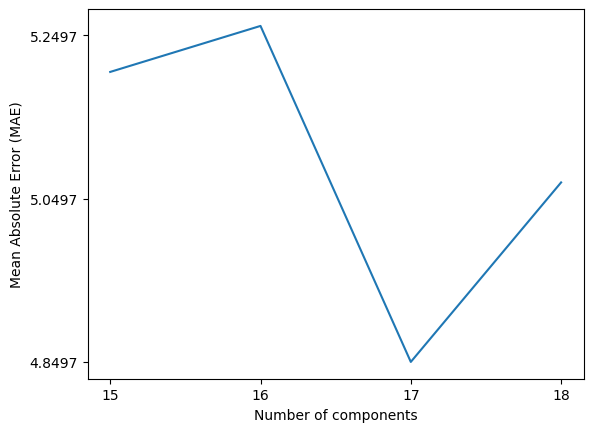

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


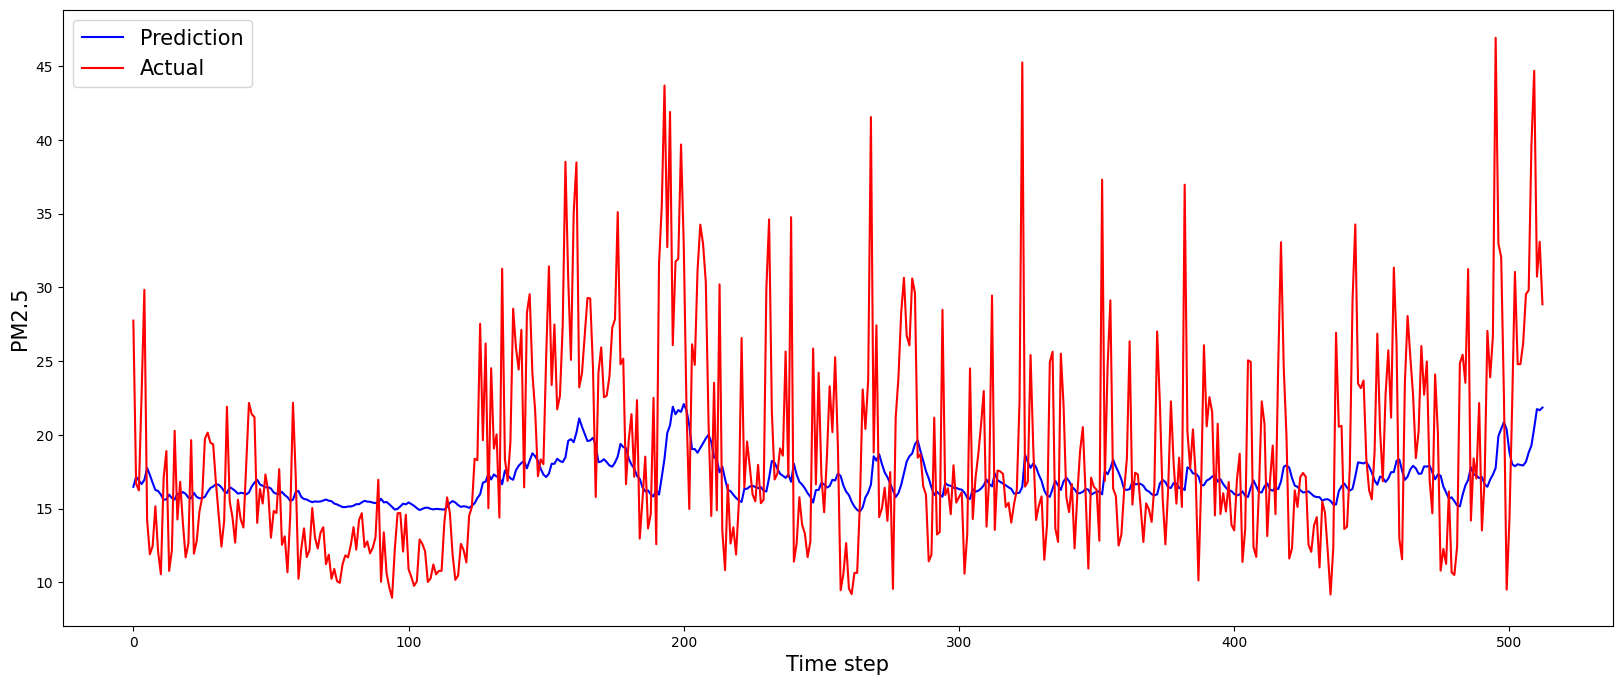

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.84965


In [88]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [89]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,-0.120118,1.847617,0.070599,-0.880094,-0.893315,2.978199,-0.205802,0.690955,0.374634,0.799076,0.299393,-0.334529,-0.729923,0.004514,-0.805621,-0.469067,-0.286717,201
2021-01-02,-0.120118,1.847617,0.070599,-0.880094,-0.893315,2.978199,-0.205802,0.690955,0.374634,0.799076,0.299393,-0.334529,-0.729923,0.004514,-0.805621,-0.469067,-0.286717,201
2021-01-03,-0.121250,1.845108,0.071826,-0.880100,-0.894627,2.974879,-0.204594,0.694473,0.373966,0.800287,0.299042,-0.330879,-0.727313,0.003799,-0.807131,-0.469059,-0.284201,201
2021-01-04,-0.125572,1.842613,0.074382,-0.883488,-0.900529,2.977010,-0.202174,0.700439,0.374869,0.802373,0.300079,-0.327068,-0.725530,0.002557,-0.811812,-0.471372,-0.283470,201
2021-01-05,-0.133105,1.844559,0.077405,-0.889320,-0.911196,2.986724,-0.200833,0.710232,0.378410,0.808068,0.302566,-0.322410,-0.723406,0.001940,-0.820459,-0.474943,-0.283759,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.416209,0.820768,-0.252733,-0.153683,0.101889,0.711236,0.068193,-0.069350,0.091055,0.062881,0.074045,-0.318605,-0.609768,0.227778,0.345521,0.100024,-0.106978,216
2022-12-28,0.414585,0.817393,-0.252723,-0.153000,0.104171,0.707484,0.067905,-0.070238,0.088712,0.061980,0.075459,-0.319002,-0.609861,0.225254,0.347511,0.098819,-0.107462,216
2022-12-29,0.410894,0.807635,-0.249512,-0.151931,0.103011,0.699280,0.066104,-0.070783,0.085950,0.061201,0.076245,-0.316322,-0.604829,0.220900,0.343063,0.096037,-0.106891,216


#### Doing the loop (no pm25_3km)

In [90]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                   test_percentage=0.2,
                                   latent_dim=n,
                                   n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                   epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                   verbose=0,
                                   model_name=f"aod_lstms2s_dim_reduction_{n}_features_no_pm25_3km")
    X_aod_no_pm25_3km_scaled_lstm_s2s_encoded, encoder_model_path = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_no_pm25_3km_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features_no_pm25_3km",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_no_pm25_3km_scaled_lstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_103     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_146 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_103[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_147 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_146[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 15)        │        765 │ lstm_147[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_79    │ (None, 7, 15)     │          0 │ dense_148[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_148 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_79… │
│                     │                   │            │ lstm_147[0][1],   │
│                     │                   │            │ lstm_147[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_149 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_148[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_149[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_104 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_146 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_147 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_106     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_152 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_106[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_153 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_152[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 16)        │        816 │ lstm_153[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_81    │ (None, 7, 16)     │          0 │ dense_152[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_154 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_81… │
│                     │                   │            │ lstm_153[0][1],   │
│                     │                   │            │ lstm_153[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_155 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_154[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_155[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_107 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_152 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_153 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_109     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_158 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_109[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_159 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_158[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 17)        │        867 │ lstm_159[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_83    │ (None, 7, 17)     │          0 │ dense_156[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_160 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_83… │
│                     │                   │            │ lstm_159[0][1],   │
│                     │                   │            │ lstm_159[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_161 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_160[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_161[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_110 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_158 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_159 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_112     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_164 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_112[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_165 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_164[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_160 (Dense)   │ (None, 18)        │        918 │ lstm_165[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_85    │ (None, 7, 18)     │          0 │ dense_160[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_166 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_85… │
│                     │                   │            │ lstm_165[0][1],   │
│                     │                   │            │ lstm_165[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_167 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_166[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_167[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,210 (1.77 MB)

 Trainable params: 154,736 (604.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,474 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_113 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_164 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_165 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,718 (307.49 KB)

 Trainable params: 78,718 (307.49 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.961716207780259
N = 16 - MAE = 4.475559137279217
N = 17 - MAE = 5.3223349590272075
N = 18 - MAE = 5.071499236453598


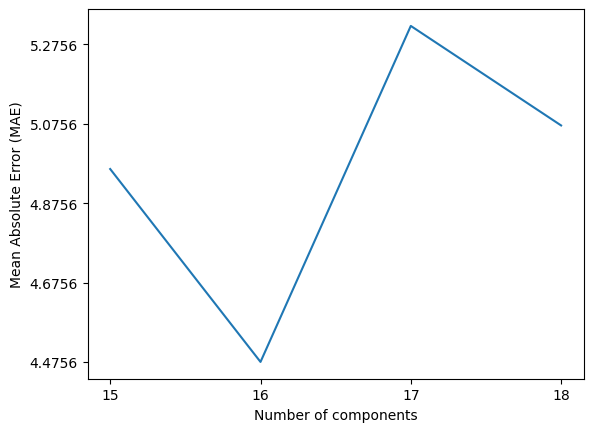

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


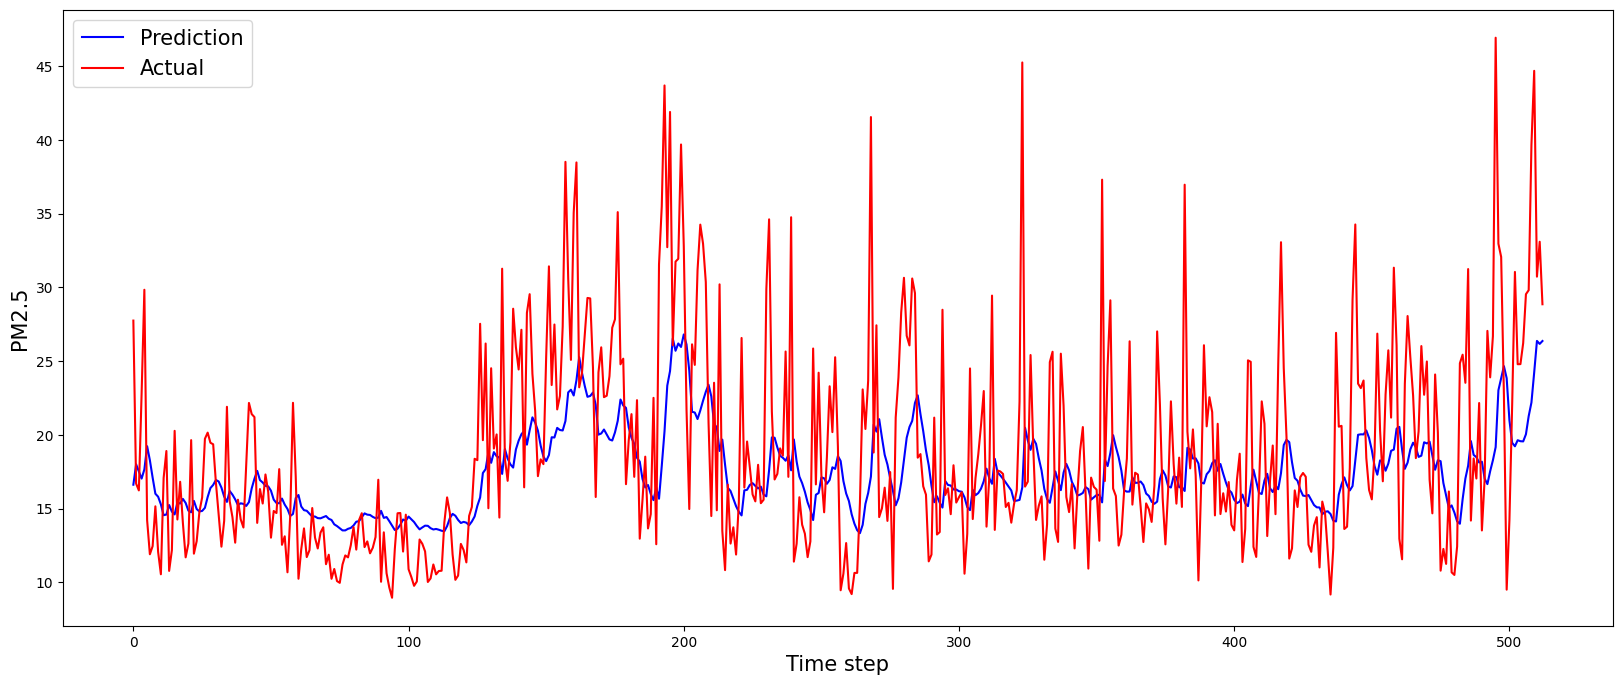

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.849650
1,No,LSTM-Seq2Seq,16,LSTM,4.475559


In [91]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [92]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_lstms2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,station
time,,,,,,,,,,,,,,,,,
2021-01-01,-0.432193,-0.253824,0.130527,0.031317,-0.057062,-0.233840,-0.076151,-0.106849,-0.600428,0.344373,0.163375,-0.445303,0.024934,-0.104849,0.019355,-0.083951,201
2021-01-02,-0.432193,-0.253824,0.130527,0.031317,-0.057062,-0.233840,-0.076151,-0.106849,-0.600428,0.344373,0.163375,-0.445303,0.024934,-0.104849,0.019355,-0.083951,201
2021-01-03,-0.431067,-0.254101,0.129748,0.030945,-0.058426,-0.233205,-0.075863,-0.106778,-0.599780,0.344013,0.162485,-0.444234,0.023813,-0.104580,0.019726,-0.084881,201
2021-01-04,-0.428844,-0.253795,0.129055,0.030508,-0.059833,-0.232734,-0.076602,-0.106430,-0.599208,0.342913,0.160888,-0.442286,0.021534,-0.104151,0.019774,-0.086893,201
2021-01-05,-0.426299,-0.253563,0.128538,0.031132,-0.061215,-0.232212,-0.077182,-0.105154,-0.598404,0.341913,0.158654,-0.439427,0.018488,-0.104093,0.019588,-0.090005,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.066157,-0.084035,0.013547,0.110001,-0.142018,-0.073824,-0.091736,-0.014720,-0.276270,0.003402,-0.091328,-0.188243,-0.240869,-0.006879,-0.164039,-0.126385,216
2022-12-28,-0.068228,-0.083627,0.015123,0.110239,-0.143314,-0.074763,-0.092565,-0.016554,-0.276713,0.002832,-0.090653,-0.188958,-0.240178,-0.005818,-0.164141,-0.124491,216
2022-12-29,-0.068626,-0.083962,0.014541,0.110721,-0.143209,-0.074603,-0.092281,-0.017291,-0.276339,0.003306,-0.089960,-0.188190,-0.238823,-0.004813,-0.162845,-0.124870,216


### Prediction + GRU-Seq2Seq

#### Doing the loop

In [93]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features")
    X_aod_scaled_grus2s_encoded, encoder_model_path = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_grus2s_encoded, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_prediction_with_grus2s_dim_reduction_{n}_features",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_grus2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_grus2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_115     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_40 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_115[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_41 (GRU)        │ [(None, 50),      │     22,800 │ gru_40[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 15)        │        765 │ gru_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_87    │ (None, 7, 15)     │          0 │ dense_164[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_42 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_87… │
│                     │                   │            │ gru_41[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_43 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ gru_43[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,304 (1.34 MB)

 Trainable params: 117,434 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,870 (917.46 KB)

None


Model: "aod_grus2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_116 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_40 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,865 (233.85 KB)

 Trainable params: 59,865 (233.85 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 15 - MAE = 4.390703954266571


Model: "aod_grus2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_118     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_44 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_118[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_45 (GRU)        │ [(None, 50),      │     22,800 │ gru_44[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 16)        │        816 │ gru_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_89    │ (None, 7, 16)     │          0 │ dense_168[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_89… │
│                     │                   │            │ gru_45[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_47 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ gru_47[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,907 (1.35 MB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,272 (919.04 KB)

None


Model: "aod_grus2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_119 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,916 (234.05 KB)

 Trainable params: 59,916 (234.05 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 16 - MAE = 4.20026197470658


Model: "aod_grus2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_121     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_48 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_121[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_49 (GRU)        │ [(None, 50),      │     22,800 │ gru_48[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_172 (Dense)   │ (None, 17)        │        867 │ gru_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_91    │ (None, 7, 17)     │          0 │ dense_172[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_50 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_91… │
│                     │                   │            │ gru_49[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_51 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ gru_51[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,510 (1.35 MB)

 Trainable params: 117,836 (460.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,674 (920.61 KB)

None


Model: "aod_grus2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_122 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,967 (234.25 KB)

 Trainable params: 59,967 (234.25 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 17 - MAE = 4.86969152062714


Model: "aod_grus2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_124     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_52 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_124[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_53 (GRU)        │ [(None, 50),      │     22,800 │ gru_52[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_176 (Dense)   │ (None, 18)        │        918 │ gru_53[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_93    │ (None, 7, 18)     │          0 │ dense_176[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_54 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_93… │
│                     │                   │            │ gru_53[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_55 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │      1,919 │ gru_55[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,113 (1.35 MB)

 Trainable params: 118,037 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,076 (922.18 KB)

None


Model: "aod_grus2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_125 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,018 (234.45 KB)

 Trainable params: 60,018 (234.45 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 18 - MAE = 4.3168064325164375


N = 15 - MAE = 4.390703954266571
N = 16 - MAE = 4.20026197470658
N = 17 - MAE = 4.86969152062714
N = 18 - MAE = 4.3168064325164375


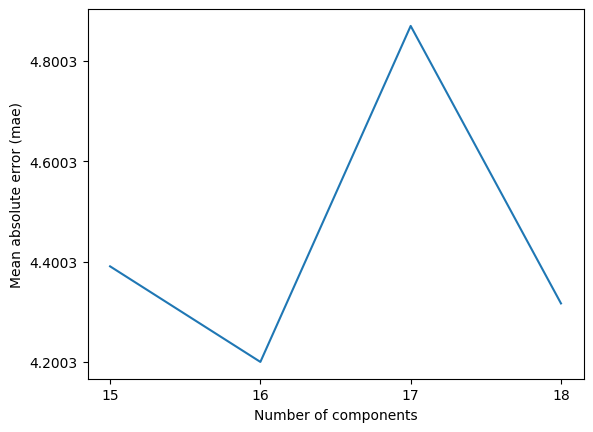

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


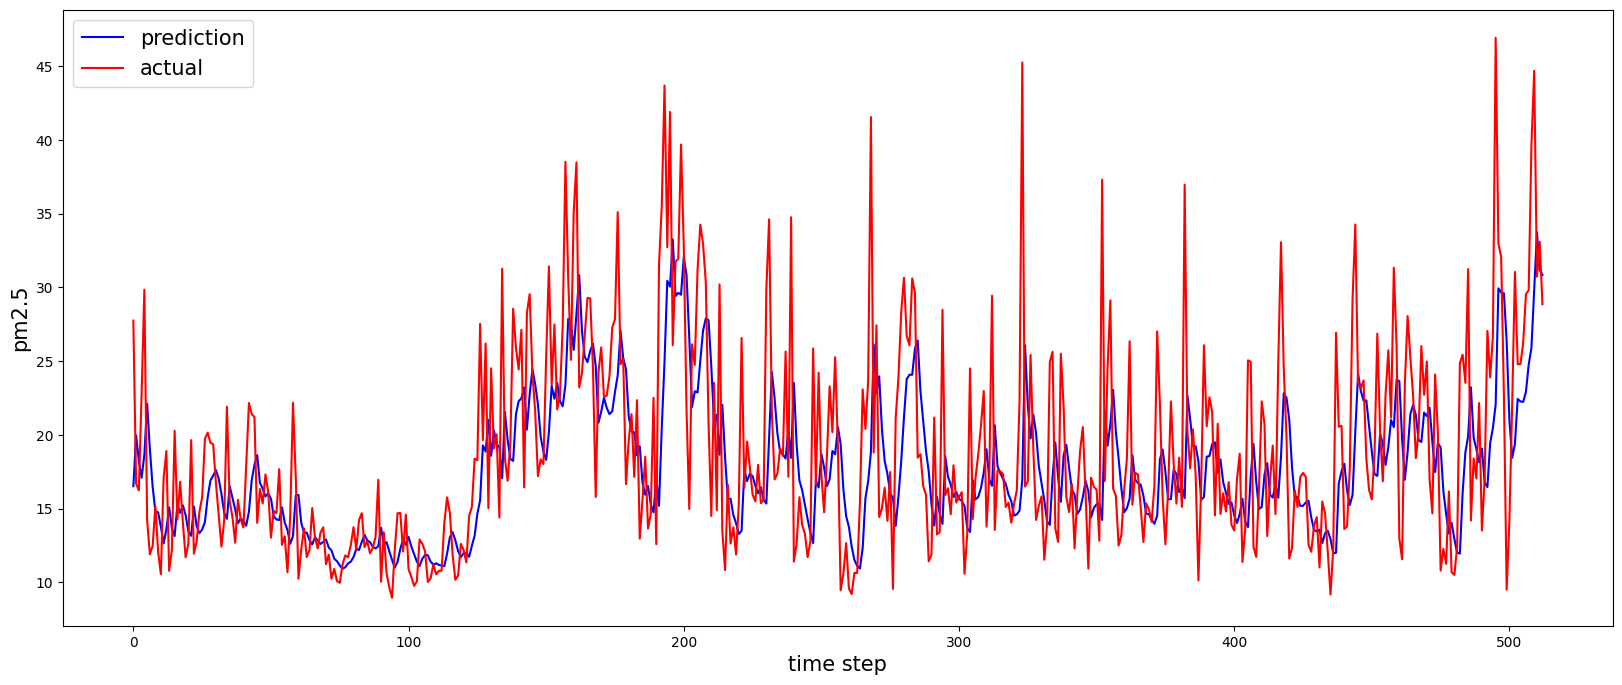

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.849650
1,No,LSTM-Seq2Seq,16,LSTM,4.475559
2,yes,GRU-Seq2Seq,16,LSTM,4.200262


In [94]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [95]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,station
time,,,,,,,,,,,,,,,,,
2021-01-01,0.063306,0.038378,0.055821,0.082172,0.065261,0.073559,0.031073,0.045833,0.080154,0.084600,0.053265,0.063119,0.067939,0.078172,0.090452,0.026896,201
2021-01-02,0.063306,0.038378,0.055821,0.082172,0.065261,0.073559,0.031073,0.045833,0.080154,0.084600,0.053265,0.063119,0.067939,0.078172,0.090452,0.026896,201
2021-01-03,0.063482,0.038421,0.055750,0.081949,0.065290,0.073554,0.030955,0.045858,0.080158,0.084787,0.053234,0.063136,0.068011,0.078388,0.090302,0.026724,201
2021-01-04,0.063579,0.038428,0.055876,0.081492,0.065161,0.073466,0.030794,0.046001,0.080087,0.085089,0.053291,0.063262,0.067989,0.078735,0.090264,0.026486,201
2021-01-05,0.063454,0.038132,0.056171,0.081118,0.064880,0.073105,0.030745,0.046149,0.080119,0.085483,0.053260,0.063552,0.067852,0.079253,0.090427,0.026301,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.048583,0.026200,0.084256,0.131705,0.048706,0.039505,0.058359,0.038752,0.080539,0.037775,0.047446,0.097736,0.089603,0.050588,0.066473,0.053774,216
2022-12-28,0.048682,0.026287,0.084351,0.131181,0.048823,0.039413,0.058067,0.038646,0.080277,0.037779,0.047662,0.097842,0.090041,0.050405,0.066718,0.053825,216
2022-12-29,0.048743,0.026218,0.084251,0.131084,0.048943,0.039485,0.057848,0.038626,0.080127,0.037827,0.047724,0.097822,0.090020,0.050432,0.066909,0.053941,216


#### Doing the loop (no pm25_3km)

In [96]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features_no_pm25_3km")
    X_aod_scaled_grus2s_encoded_no_pm25_3km, encoder_model_path = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_grus2s_encoded_no_pm25_3km, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_prediction_with_grus2s_dim_reduction_{n}_features_no_pm25_3km",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_grus2s_encoded_no_pm25_3km
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_grus2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_127     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_56 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_127[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_57 (GRU)        │ [(None, 50),      │     22,800 │ gru_56[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_180 (Dense)   │ (None, 15)        │        765 │ gru_57[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_95    │ (None, 7, 15)     │          0 │ dense_180[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_58 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_95… │
│                     │                   │            │ gru_57[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_59 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_59[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_grus2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_128 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_57 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 15 - MAE = 4.897953698709818


Model: "aod_grus2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_130     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_60 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_130[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_61 (GRU)        │ [(None, 50),      │     22,800 │ gru_60[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 16)        │        816 │ gru_61[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_97    │ (None, 7, 16)     │          0 │ dense_184[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_62 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_97… │
│                     │                   │            │ gru_61[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_63 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_62[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_63[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_grus2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_131 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_60 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 16 - MAE = 4.2380684853326995


Model: "aod_grus2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_133     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_64 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_133[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_65 (GRU)        │ [(None, 50),      │     22,800 │ gru_64[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_188 (Dense)   │ (None, 17)        │        867 │ gru_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_99    │ (None, 7, 17)     │          0 │ dense_188[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_66 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_99… │
│                     │                   │            │ gru_65[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_67 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_67[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_grus2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_134 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_64 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_65 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 17 - MAE = 4.5388199056353775


Model: "aod_grus2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_136     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_68 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_136[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_69 (GRU)        │ [(None, 50),      │     22,800 │ gru_68[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_192 (Dense)   │ (None, 18)        │        918 │ gru_69[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_101   │ (None, 7, 18)     │          0 │ dense_192[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_70 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_10… │
│                     │                   │            │ gru_69[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_71 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_70[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_71[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,910 (1.35 MB)

 Trainable params: 117,636 (459.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,274 (919.04 KB)

None


Model: "aod_grus2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_137 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_68 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_69 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,718 (233.27 KB)

 Trainable params: 59,718 (233.27 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 18 - MAE = 4.347055533468708


N = 15 - MAE = 4.897953698709818
N = 16 - MAE = 4.2380684853326995
N = 17 - MAE = 4.5388199056353775
N = 18 - MAE = 4.347055533468708


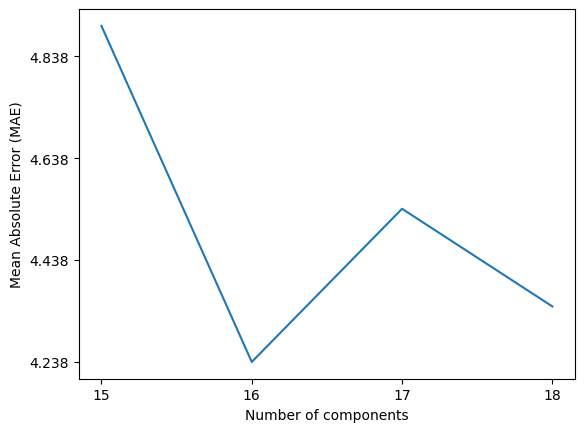

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


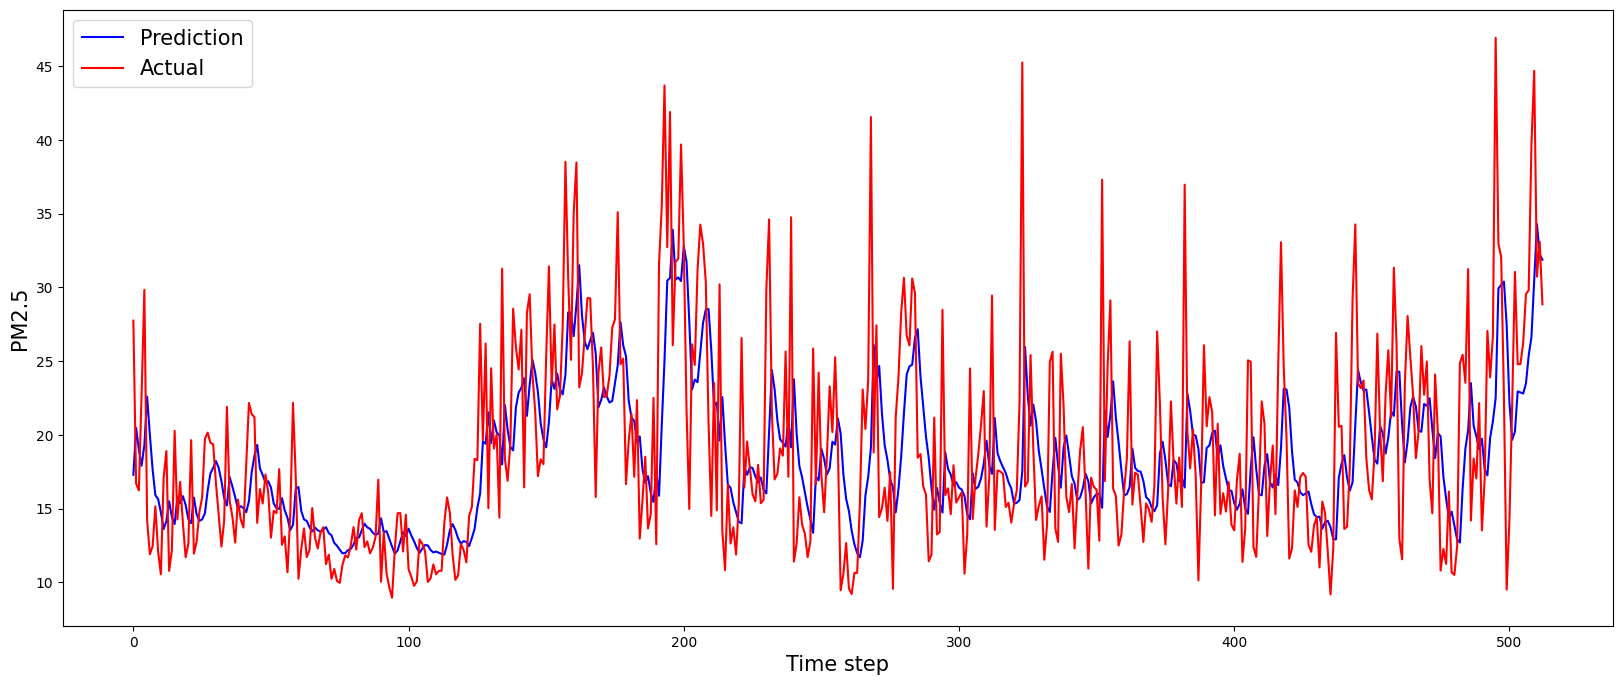

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.849650
1,No,LSTM-Seq2Seq,16,LSTM,4.475559
2,yes,GRU-Seq2Seq,16,LSTM,4.200262
3,No,GRU-Seq2Seq,16,LSTM,4.238068


In [97]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [98]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_no_pm25_3km.csv"))
df_grus2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,station
time,,,,,,,,,,,,,,,,,
2021-01-01,0.045307,0.046902,0.064789,0.038005,0.074943,0.025936,0.033836,0.035169,0.033630,0.031386,0.039588,0.068416,0.014870,0.040380,0.288754,0.118090,201
2021-01-02,0.045307,0.046902,0.064789,0.038005,0.074943,0.025936,0.033836,0.035169,0.033630,0.031386,0.039588,0.068416,0.014870,0.040380,0.288754,0.118090,201
2021-01-03,0.045368,0.046708,0.065023,0.038277,0.075147,0.026049,0.033892,0.035185,0.033511,0.031548,0.039630,0.068413,0.014928,0.040304,0.288442,0.117576,201
2021-01-04,0.045334,0.046365,0.065191,0.038513,0.075453,0.026000,0.033875,0.034993,0.033316,0.031544,0.039558,0.068191,0.014887,0.040097,0.289202,0.117482,201
2021-01-05,0.045252,0.046132,0.065336,0.038689,0.075734,0.025802,0.033681,0.034683,0.033133,0.031358,0.039478,0.067789,0.014779,0.039905,0.290467,0.117782,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.089146,0.076971,0.067770,0.051430,0.024657,0.043614,0.081521,0.052873,0.063921,0.089499,0.078714,0.051166,0.043208,0.057390,0.073947,0.054173,216
2022-12-28,0.089305,0.076663,0.067813,0.051677,0.024814,0.043446,0.081647,0.052927,0.063527,0.089230,0.078985,0.050835,0.043403,0.057170,0.074457,0.054104,216
2022-12-29,0.089328,0.076600,0.067730,0.051912,0.024821,0.043317,0.081540,0.052843,0.063390,0.089029,0.079379,0.050806,0.043449,0.057050,0.074481,0.054327,216


### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [99]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_scaled,
                                        test_percentage=0.2,
                                        latent_dim=n,
                                        n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                        epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                        verbose=0,
                                        model_name=f"aod_cnnlstms2s_dim_reduction_{n}_features")

    X_aod_scaled_cnnlstms2s_encoded, encoder_model_path = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstms2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_cnnlstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstms2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_cnnlstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_139     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_139[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1, 12)     │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12)        │          0 │ max_pooling1d_10… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_103   │ (None, 7, 12)     │          0 │ flatten_10[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_186 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_196 (Dense)   │ (None, 15)        │        765 │ lstm_186[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_104   │ (None, 7, 15)     │          0 │ dense_196[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_187 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_186[0][1],   │
│                     │                   │            │ lstm_186[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_187[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,598 (357.81 KB)

 Trainable params: 30,532 (119.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,066 (238.54 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_140 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_103               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_186 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,633 (61.07 KB)

 Trainable params: 15,633 (61.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_142     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_142[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 1, 12)     │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 12)        │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_106   │ (None, 7, 12)     │          0 │ flatten_11[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_190 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_201 (Dense)   │ (None, 16)        │        816 │ lstm_190[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_107   │ (None, 7, 16)     │          0 │ dense_201[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_191 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_10… │
│                     │                   │            │ lstm_190[0][1],   │
│                     │                   │            │ lstm_190[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_191[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,351 (360.75 KB)

 Trainable params: 30,783 (120.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,568 (240.50 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_143 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_106               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_190 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,684 (61.27 KB)

 Trainable params: 15,684 (61.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_145     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_145[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 1, 12)     │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 12)        │          0 │ max_pooling1d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_109   │ (None, 7, 12)     │          0 │ flatten_12[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_194 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_206 (Dense)   │ (None, 17)        │        867 │ lstm_194[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_110   │ (None, 7, 17)     │          0 │ dense_206[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_195 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_11… │
│                     │                   │            │ lstm_194[0][1],   │
│                     │                   │            │ lstm_194[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_195[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,104 (363.69 KB)

 Trainable params: 31,034 (121.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,070 (242.46 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_146 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_109               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_194 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,735 (61.46 KB)

 Trainable params: 15,735 (61.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_148     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_148[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 1, 12)     │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 12)        │          0 │ max_pooling1d_13… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_112   │ (None, 7, 12)     │          0 │ flatten_13[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_198 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_211 (Dense)   │ (None, 18)        │        918 │ lstm_198[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_113   │ (None, 7, 18)     │          0 │ dense_211[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_199 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_11… │
│                     │                   │            │ lstm_198[0][1],   │
│                     │                   │            │ lstm_198[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_199[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,857 (366.63 KB)

 Trainable params: 31,285 (122.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,572 (244.43 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_149 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_112               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_198 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,786 (61.66 KB)

 Trainable params: 15,786 (61.66 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.718010201862615
N = 16 - MAE = 4.5541597986694935
N = 17 - MAE = 4.388345908727668
N = 18 - MAE = 4.560140078754947


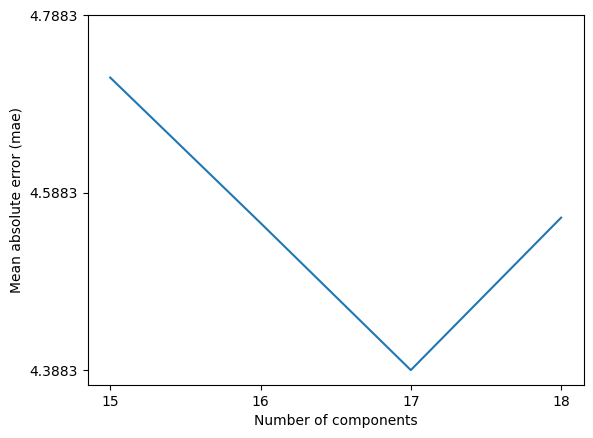

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


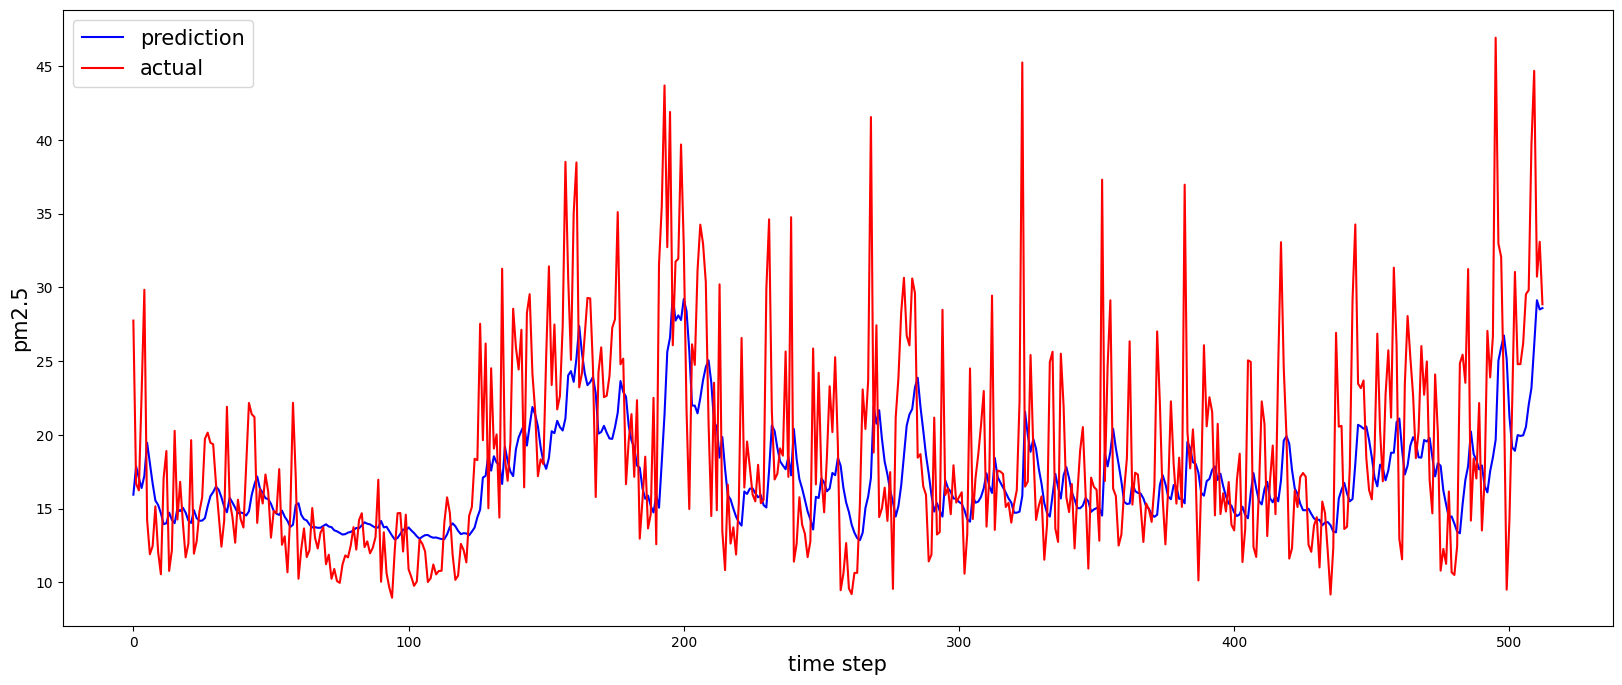

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.849650
1,No,LSTM-Seq2Seq,16,LSTM,4.475559
2,yes,GRU-Seq2Seq,16,LSTM,4.200262
3,No,GRU-Seq2Seq,16,LSTM,4.238068
4,Yes,CNNLSTM-Seq2Seq,17,LSTM,4.388346


In [100]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [101]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,-0.387849,-0.186673,0.123787,-0.097699,-0.200900,0.515979,-0.228108,-0.026146,0.003679,-0.202456,-0.694426,-0.159782,0.078120,0.177390,0.066775,-0.033301,-0.418697,201
2021-01-02,-0.387849,-0.186673,0.123787,-0.097699,-0.200900,0.515979,-0.228108,-0.026146,0.003679,-0.202456,-0.694426,-0.159782,0.078120,0.177390,0.066775,-0.033301,-0.418697,201
2021-01-03,-0.387849,-0.186673,0.123787,-0.097699,-0.200900,0.515979,-0.228108,-0.026146,0.003679,-0.202456,-0.694426,-0.159782,0.078120,0.177390,0.066775,-0.033301,-0.418697,201
2021-01-04,-0.387893,-0.186699,0.123794,-0.097707,-0.200911,0.516027,-0.228128,-0.026142,0.003657,-0.202483,-0.694523,-0.159811,0.078127,0.177411,0.066794,-0.033318,-0.418735,201
2021-01-05,-0.387395,-0.185587,0.124133,-0.097223,-0.200886,0.514792,-0.227549,-0.025402,0.005529,-0.202767,-0.692543,-0.159817,0.076526,0.176934,0.067983,-0.033462,-0.417711,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.275776,0.013319,0.265853,-0.025636,-0.133400,0.306379,-0.155382,-0.370989,0.291561,0.012724,-0.284556,0.019334,0.128469,0.028237,-0.182615,0.221711,-0.347970,216
2022-12-28,-0.274775,0.012148,0.263867,-0.025908,-0.133469,0.305727,-0.155626,-0.367974,0.289988,0.011806,-0.283694,0.019426,0.127865,0.028601,-0.181537,0.220802,-0.346527,216
2022-12-29,-0.273385,0.012606,0.263172,-0.026005,-0.132780,0.304931,-0.153939,-0.367578,0.289866,0.012504,-0.282823,0.019186,0.127089,0.027740,-0.180895,0.218496,-0.344275,216


#### Doing the loop (no pm25_3km)

In [102]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                        test_percentage=0.2,
                                        latent_dim=n,
                                        n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                        epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                        verbose=0,
                                        model_name=f"aod_cnnlstms2s_dim_reduction_{n}_features_no_pm25_3km")

    X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km, encoder_model_path = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_cnnlstms2s_dim_reduction_{n}_features_no_pm25_3km",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_151     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_151[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 1, 12)     │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 12)        │          0 │ max_pooling1d_14… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_115   │ (None, 7, 12)     │          0 │ flatten_14[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_202 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 15)        │        765 │ lstm_202[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_116   │ (None, 7, 15)     │          0 │ dense_216[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_203 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_11… │
│                     │                   │            │ lstm_202[0][1],   │
│                     │                   │            │ lstm_202[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_203[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,307 (356.67 KB)

 Trainable params: 30,435 (118.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,872 (237.79 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_152 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_115               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_202 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,561 (60.79 KB)

 Trainable params: 15,561 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_154     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_154[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 1, 12)     │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 12)        │          0 │ max_pooling1d_15… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_118   │ (None, 7, 12)     │          0 │ flatten_15[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_206 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_221 (Dense)   │ (None, 16)        │        816 │ lstm_206[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_119   │ (None, 7, 16)     │          0 │ dense_221[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_207 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_11… │
│                     │                   │            │ lstm_206[0][1],   │
│                     │                   │            │ lstm_206[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_207[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,060 (359.61 KB)

 Trainable params: 30,686 (119.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,374 (239.75 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_155 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_118               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_206 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,612 (60.98 KB)

 Trainable params: 15,612 (60.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_157     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_157[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 1, 12)     │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 12)        │          0 │ max_pooling1d_16… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_121   │ (None, 7, 12)     │          0 │ flatten_16[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_210 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_12… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_226 (Dense)   │ (None, 17)        │        867 │ lstm_210[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_122   │ (None, 7, 17)     │          0 │ dense_226[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_211 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_12… │
│                     │                   │            │ lstm_210[0][1],   │
│                     │                   │            │ lstm_210[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_211[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,813 (362.55 KB)

 Trainable params: 30,937 (120.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,876 (241.71 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_158 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_121               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_210 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,663 (61.18 KB)

 Trainable params: 15,663 (61.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_160     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_160[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 1, 12)     │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 12)        │          0 │ max_pooling1d_17… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_124   │ (None, 7, 12)     │          0 │ flatten_17[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_214 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_12… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_231 (Dense)   │ (None, 18)        │        918 │ lstm_214[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_125   │ (None, 7, 18)     │          0 │ dense_231[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_215 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_12… │
│                     │                   │            │ lstm_214[0][1],   │
│                     │                   │            │ lstm_214[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_215[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,566 (365.50 KB)

 Trainable params: 31,188 (121.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,378 (243.67 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_161 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_124               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_214 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,714 (61.38 KB)

 Trainable params: 15,714 (61.38 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.560831569632015
N = 16 - MAE = 5.0311949247232866
N = 17 - MAE = 4.802802906135424
N = 18 - MAE = 4.818784579756083


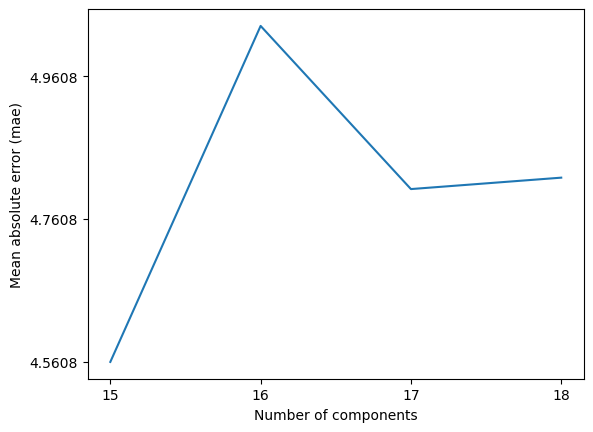

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


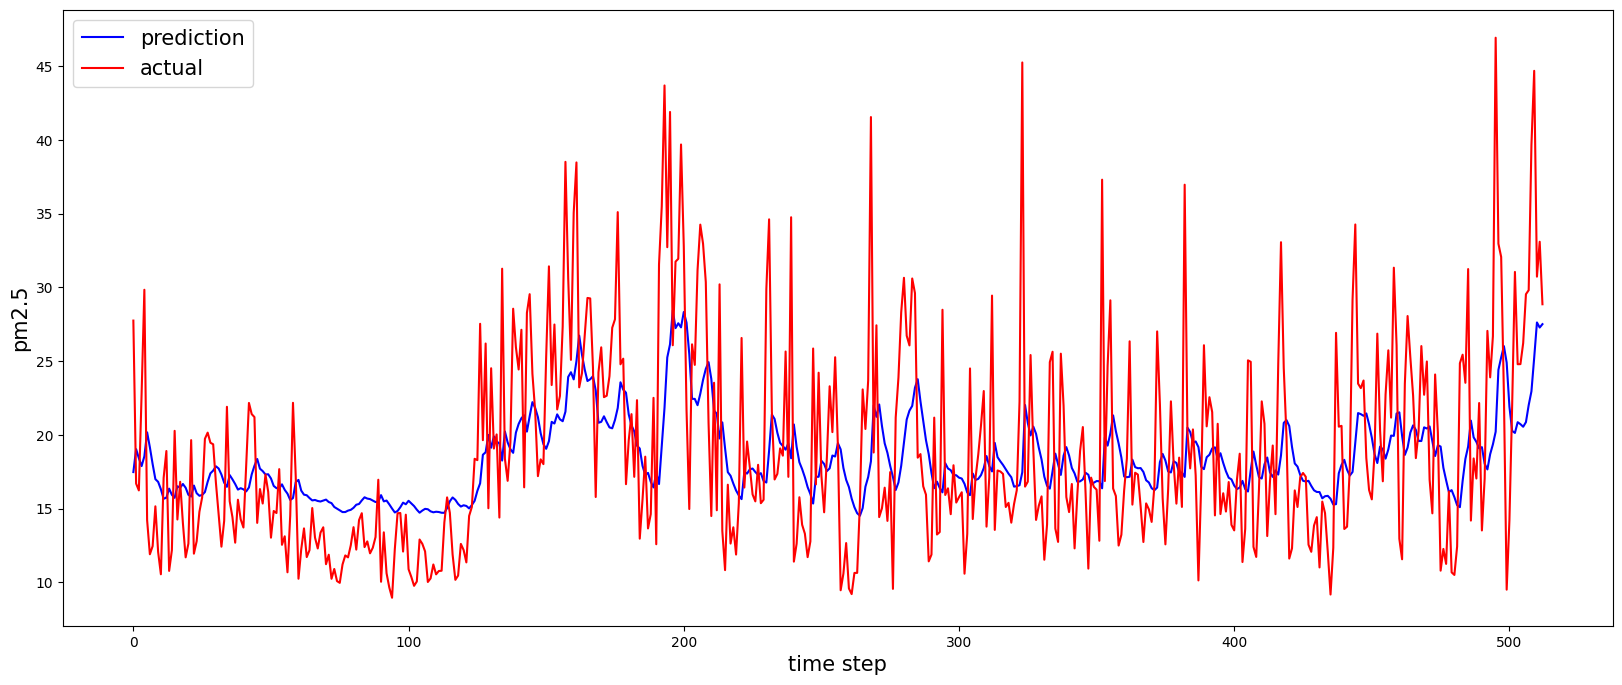

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,17,LSTM,4.849650
1,No,LSTM-Seq2Seq,16,LSTM,4.475559
2,yes,GRU-Seq2Seq,16,LSTM,4.200262
3,No,GRU-Seq2Seq,16,LSTM,4.238068
4,Yes,CNNLSTM-Seq2Seq,17,LSTM,4.388346
5,No,CNNLSTM-Seq2Seq,15,LSTM,4.560832


In [103]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [104]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_cnnlstms2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,station
time,,,,,,,,,,,,,,,,
2021-01-01,-0.139998,0.166955,0.172853,0.413346,0.270357,-0.389775,0.231446,0.133074,0.026896,-0.107726,-0.111300,0.068394,-0.227210,0.365856,-0.003271,201
2021-01-02,-0.139998,0.166955,0.172853,0.413346,0.270357,-0.389775,0.231446,0.133074,0.026896,-0.107726,-0.111300,0.068394,-0.227210,0.365856,-0.003271,201
2021-01-03,-0.139998,0.166955,0.172853,0.413346,0.270357,-0.389775,0.231446,0.133074,0.026896,-0.107726,-0.111300,0.068394,-0.227210,0.365856,-0.003271,201
2021-01-04,-0.139910,0.167154,0.172158,0.416638,0.272603,-0.388769,0.233816,0.135493,0.027573,-0.110009,-0.110368,0.068360,-0.228382,0.365671,-0.000935,201
2021-01-05,-0.138488,0.166010,0.170174,0.417120,0.273082,-0.385000,0.234611,0.137310,0.028251,-0.111785,-0.109392,0.067825,-0.228334,0.363268,0.001379,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.222274,-0.062536,-0.093419,0.232102,-0.132296,-0.589355,-0.328686,-0.220488,0.146484,0.130857,0.097103,-0.089525,-0.300755,0.147856,-0.069139,216
2022-12-28,0.217592,-0.054600,-0.079911,0.233046,-0.125268,-0.581976,-0.325552,-0.216698,0.146722,0.129443,0.097835,-0.092070,-0.298654,0.149849,-0.068055,216
2022-12-29,0.216606,-0.065693,-0.086121,0.223011,-0.130306,-0.567052,-0.319937,-0.210176,0.139364,0.133109,0.091195,-0.086484,-0.285160,0.142129,-0.072215,216


## Compare the score

In [105]:
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


### LSTM-Seq2Seq

In [106]:
print(df_lstms2s_reduced.shape)
df_lstms2s_reduced

(2573, 18)


,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,-0.120118,1.847617,0.070599,-0.880094,-0.893315,2.978199,-0.205802,0.690955,0.374634,0.799076,0.299393,-0.334529,-0.729923,0.004514,-0.805621,-0.469067,-0.286717,201
2021-01-02,-0.120118,1.847617,0.070599,-0.880094,-0.893315,2.978199,-0.205802,0.690955,0.374634,0.799076,0.299393,-0.334529,-0.729923,0.004514,-0.805621,-0.469067,-0.286717,201
2021-01-03,-0.121250,1.845108,0.071826,-0.880100,-0.894627,2.974879,-0.204594,0.694473,0.373966,0.800287,0.299042,-0.330879,-0.727313,0.003799,-0.807131,-0.469059,-0.284201,201
2021-01-04,-0.125572,1.842613,0.074382,-0.883488,-0.900529,2.977010,-0.202174,0.700439,0.374869,0.802373,0.300079,-0.327068,-0.725530,0.002557,-0.811812,-0.471372,-0.283470,201
2021-01-05,-0.133105,1.844559,0.077405,-0.889320,-0.911196,2.986724,-0.200833,0.710232,0.378410,0.808068,0.302566,-0.322410,-0.723406,0.001940,-0.820459,-0.474943,-0.283759,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.416209,0.820768,-0.252733,-0.153683,0.101889,0.711236,0.068193,-0.069350,0.091055,0.062881,0.074045,-0.318605,-0.609768,0.227778,0.345521,0.100024,-0.106978,216
2022-12-28,0.414585,0.817393,-0.252723,-0.153000,0.104171,0.707484,0.067905,-0.070238,0.088712,0.061980,0.075459,-0.319002,-0.609861,0.225254,0.347511,0.098819,-0.107462,216
2022-12-29,0.410894,0.807635,-0.249512,-0.151931,0.103011,0.699280,0.066104,-0.070783,0.085950,0.061201,0.076245,-0.316322,-0.604829,0.220900,0.343063,0.096037,-0.106891,216


In [107]:
y_pred = predictLSTMNoSplit(df_lstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_lstm_prediction_no_split_with_lstms2s_dim_reduction_{df_lstms2s_reduced.shape[-1]}_features",
                           verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


In [108]:
print(y_pred.shape)
y_pred

(2573, 1, 1)


array([[[0.14938658]],

       [[0.14938658]],

       [[0.1548705 ]],

       ...,

       [[0.21650466]],

       [[0.21364929]],

       [[0.21424556]]], dtype=float32)

In [109]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

,0
0,0.149387
1,0.149387
2,0.154870
3,0.163855
4,0.170768
...,...
2568,0.190403
2569,0.203391
2570,0.216505
2571,0.213649


In [110]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

array([[17.25      ],
       [23.        ],
       [28.29166667],
       ...,
       [30.7247081 ],
       [33.09142799],
       [28.85406871]])

In [111]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

array([[17.443672],
       [17.443672],
       [17.894789],
       ...,
       [22.964926],
       [22.730036],
       [22.779087]], dtype=float32)

6.053431719810966
7.768970258629239


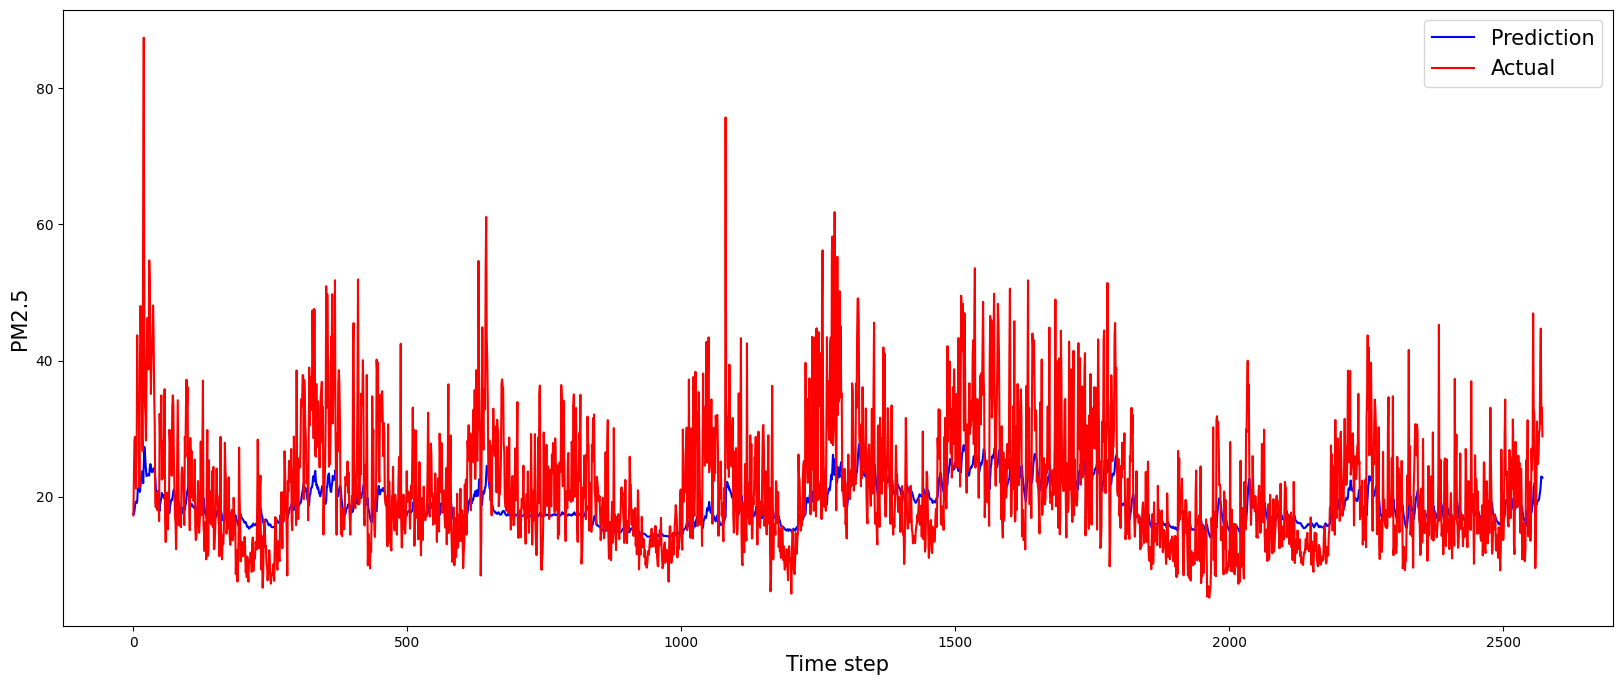

In [112]:
# Print out the MAE
print(mean_absolute_error(inv_y_aod, inv_y_pred))
print(mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"]))

# Visualization
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

In [113]:
stophere

NameError: name 'stophere' is not defined

### GRU-Seq2Seq

In [ ]:
print(df_grus2s_reduced.shape)
df_grus2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_grus2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_gru_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### CNNLSTM-Seq2Seq

In [ ]:
print(df_cnnlstms2s_reduced.shape)
df_cnnlstms2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_cnnlstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_cnnlstm_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")